In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl


In [3]:
# Import OpenSense modules as submodules
import sys
import os

sys.path.append(os.path.abspath("./pycomlink/"))
sys.path.append(os.path.abspath("./poligrain/src/"))

import pycomlink as pycml 
import poligrain as plg

# OpenMRG analysis
OPEN FILES

In [4]:
dataset = 'OpenMRG'
adj_path = 'data/adjusted_fields/'

ds_gauges = xr.open_dataset('data/andersson_2022_OpenMRG/gauges/openmrg_gauges.nc')     
ds_rad = xr.open_dataset("data/andersson_2022_OpenMRG/radar/openmrg_rad.nc")          
ds_cmls = xr.open_dataset("data/processed_cml_OpenMRG.nc").R_acc                              

# adding adjusted field and naming
ds_rad = ds_rad.rename({'rainfall_amount':'radar'})  
ds_rad['add_p_idw']=xr.open_dataset(adj_path+dataset+'_add_p_idw.nc').add_p_idw
ds_rad['add_p_ok']=xr.open_dataset(adj_path+dataset+'_add_p_ok.nc').add_p_ok
ds_rad['add_b_ok']=xr.open_dataset(adj_path+dataset+'_add_b_ok.nc').add_b_ok
ds_rad['mul_p_idw']=xr.open_dataset(adj_path+dataset+'_mul_p_idw.nc').mul_p_idw
ds_rad['mul_p_ok']=xr.open_dataset(adj_path+dataset+'_mul_p_ok.nc').mul_p_ok
ds_rad['mul_b_ok']=xr.open_dataset(adj_path+dataset+'_mul_b_ok.nc').mul_b_ok
ds_rad['ked_p']=xr.open_dataset(adj_path+dataset+'_ked_p.nc').ked_p
ds_rad['ked_b']=xr.open_dataset(adj_path+dataset+'_ked_b.nc').ked_b

fields = ['radar', 'add_p_idw', 'add_p_ok', 
          'add_b_ok', 'ked_p', 'ked_b',
          'mul_p_idw', 'mul_p_ok', 'mul_b_ok']

# 40 km2 VIEW

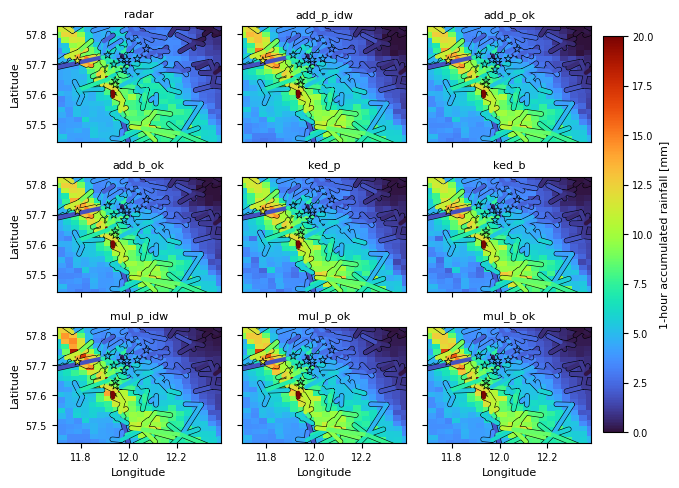

In [5]:
seltime = '2015-08-25T08:00'

target_lon = np.abs(np.nanmin(ds_rad.x_grid.values.flatten()) +  np.nanmax(ds_rad.x_grid.values.flatten()))/2
target_lat = np.abs(np.nanmin(ds_rad.y_grid.values.flatten()) +  np.nanmax(ds_rad.y_grid.values.flatten()))/2
low_lon = target_lon - 20000
up_lon = target_lon + 20000
low_lat = target_lat - 20000
up_lat = target_lat + 20000
mask = (ds_rad.x_grid >=  low_lon)&(ds_rad.x_grid <=  up_lon)&(ds_rad.y_grid >=  low_lat)&(ds_rad.y_grid <=  up_lat)
ds_rad_cut = ds_rad.where(mask, drop=True)
low_lon = np.nanmin(ds_rad_cut.lon)
low_lat = np.nanmin(ds_rad_cut.lat)
up_lon = np.nanmax(ds_rad_cut.lon)
up_lat = np.nanmax(ds_rad_cut.lat)

fig, ax = plt.subplots(3, 3, figsize=(6.5, 5), sharex=True, sharey=True)
axes = ax.flatten()

# Colormap settings
cmap = "turbo"
vmin, vmax = 0, 20
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for i  in range(0, len(axes)):
    plg.plot_map.plot_plg(
        da_grid=ds_rad[fields[i]].sel(time=seltime),
        da_gauges=ds_gauges.rainfall_amount.sel(time=seltime),
        da_cmls=ds_cmls.sel(time=seltime),
        use_lon_lat=True,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False,
        ax=axes[i],
        kwargs_cmls_plot={"edge_color": "black", "edge_width": 0.8, "line_width": 3},
        kwargs_gauges_plot={"edge_color": "black", "s": 35, "marker": "*"}
    )
    axes[i].set_title(fields[i], fontsize=8)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_xlim([low_lon, up_lon])
    axes[i].set_ylim([low_lat, up_lat])

# Axis labels only on outer edges
for i in [0, 3, 6]:
    axes[i].set_ylabel('Latitude', fontsize=8)
for i in [6, 7, 8]:
    axes[i].set_xlabel('Longitude', fontsize=8)

# Compact layout and shared colorbar
plt.tight_layout(pad=1.0)
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.035, pad=0.02)
cbar.set_label('1-hour accumulated rainfall [mm]', fontsize=8)
cbar.ax.tick_params(labelsize=7)

# Consistent tick label size
for ax in axes:
    ax.tick_params(axis='both', labelsize=7)

# Save figure for Overleaf
fig.savefig('OpenMRG_case_study.png', dpi=300, bbox_inches='tight')
plt.show()


# diff at gaguges

In [6]:
names = ['rad_dif', 'add_p_idw_dif', 'add_p_ok_dif', 
         'add_b_ok_dif', 'ked_p_dif', 'ked_b_dif', 
         'mul_p_idw_dif', 'mul_p_ok_dif', 'mul_b_ok_dif']

for field, name in zip(fields, names):
    ds_rad[name] = ds_rad['radar'] - ds_rad[field]


get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), 
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best" 
)

for field, name in zip(fields, names):
    ds_gauges[field] = get_grid_at_points(
        da_gridded_data=ds_rad[field],
        da_point_data=ds_gauges.rainfall_amount,  
    )
    ds_gauges[name] = ds_gauges['rainfall_amount'] - ds_gauges[field]

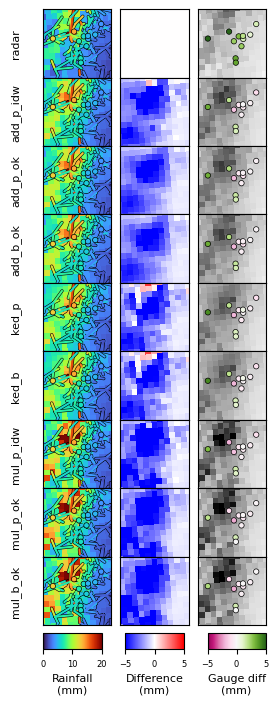

In [7]:
# -------------------------------
# 1️⃣ Configuration
# -------------------------------
seltime = '2015-08-27T10:00'

diff_fields = [
    'rad_dif', 'add_p_idw_dif', 'add_p_ok_dif',
    'add_b_ok_dif', 'ked_p_dif', 'ked_b_dif',
    'mul_p_idw_dif', 'mul_p_ok_dif', 'mul_b_ok_dif'
]

# -------------------------------
# 2️⃣ Define map extents
# -------------------------------
target_lon = np.abs(np.nanmin(ds_gauges.x.values.flatten()) + np.nanmax(ds_gauges.x.values.flatten())) / 2
target_lat = np.abs(np.nanmin(ds_gauges.y.values.flatten()) + np.nanmax(ds_gauges.y.values.flatten())) / 2

low_lon = target_lon - 12000
up_lon = target_lon + 12000
low_lat = target_lat - 12000
up_lat = target_lat + 12000

# -------------------------------
# 3️⃣ Figure and colormap settings
# -------------------------------
fig, ax = plt.subplots(9, 3, figsize=(3,8), sharex=True, sharey=True)

vmin_rmap, vmax_rmap = 0, 20
cmap_rmap = "turbo"

vmin_dmap, vmax_dmap = -5, 5
cmap_dmap = "bwr"
norm_dmap = mpl.colors.Normalize(vmin=vmin_dmap, vmax=vmax_dmap)

vmin_rg, vmax_rg = -5, 5
cmap_rg = "PiYG"
norm_rg = mpl.colors.Normalize(vmin=vmin_rg, vmax=vmax_rg)

# -------------------------------
# 4️⃣ Plot maps
# -------------------------------
for i in range(9):
    # First column: radar + gauges
    plg.plot_map.plot_plg(
        da_grid=ds_rad[fields[i]].sel(time=seltime),
        da_gauges=ds_gauges.rainfall_amount.sel(time=seltime),
        da_cmls=ds_cmls.sel(time=seltime),
        use_lon_lat=False,
        vmin=vmin_rmap, vmax=vmax_rmap,
        add_colorbar=False,
        ax=ax[i, 0],
        kwargs_cmls_plot={"edge_color": "black", "edge_width": 0.8, "line_width": 1.5},
        kwargs_gauges_plot={"edge_color": "black", "s": 15}
    )
    ax[i, 0].set_xlim([low_lon, up_lon])
    ax[i, 0].set_ylim([low_lat, up_lat])
    ax[i, 0].set_title('')
    ax[i, 0].set_xlabel('')
    ax[i, 0].set_ylabel('')
    ax[i, 0].tick_params(axis='both', labelsize=6)
    ax[i, 0].set_aspect('equal')  # 
    ax[i, 0].text(-0.32, 0.5, fields[i], va='center', ha='right',
                  rotation='vertical', fontsize=8, transform=ax[i, 0].transAxes)
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    # Second column: field differences
    ds_rad[diff_fields[i]].sel(time=seltime).plot(
        ax=ax[i, 1],
        x='x_grid', y='y_grid',
        vmin=vmin_dmap, vmax=vmax_dmap,
        cmap=cmap_dmap, norm=norm_dmap,
        add_colorbar=False
    )
    ax[i, 1].set_xlim([low_lon, up_lon])
    ax[i, 1].set_ylim([low_lat, up_lat])
    ax[i, 1].set_title('')
    ax[i, 1].set_xlabel('')
    ax[i, 1].set_ylabel('')
    ax[i, 1].tick_params(axis='both', labelsize=6)
    ax[i, 1].set_aspect('equal')
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

    # Third column: gray map + gauge differences
    ds_rad[fields[i]].sel(time=seltime).plot(
        ax=ax[i, 2],
        x='x_grid', y='y_grid',
        vmin=vmin_rmap, vmax=vmax_rmap,
        cmap='binary',
        add_colorbar=False
    )
    ax[i, 2].scatter(
        ds_gauges.x, ds_gauges.y,
        cmap=cmap_rg, norm=norm_rg,
        c=ds_gauges[diff_fields[i]].sel(time=seltime),
        edgecolor='black',
        s=15, linewidth=0.5
    )
    ax[i, 2].set_xlim([low_lon, up_lon])
    ax[i, 2].set_ylim([low_lat, up_lat])
    ax[i, 2].set_title('')
    ax[i, 2].set_xlabel('')
    ax[i, 2].set_ylabel('')
    ax[i, 2].tick_params(axis='both', labelsize=6)
    ax[i, 2].set_aspect('equal')
    ax[i, 2].set_xticks([])
    ax[i, 2].set_yticks([])

# -------------------------------
# 5️⃣ Add horizontal colorbars below each column
# -------------------------------
# Ottieni posizione del primo subplot di ogni colonna
pos1 = ax[-1,0].get_position()
pos2 = ax[-1,1].get_position()
pos3 = ax[-1,2].get_position()

# Crea colorbar esattamente sotto ciascuna colonna
cbar_ax1 = fig.add_axes([pos1.x0, pos1.y0 - 0.03, pos1.width, 0.02])
cbar_ax2 = fig.add_axes([pos2.x0, pos2.y0 - 0.03, pos2.width, 0.02])
cbar_ax3 = fig.add_axes([pos3.x0, pos3.y0 - 0.03, pos3.width, 0.02])

cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin_rmap, vmax=vmax_rmap),
                                         cmap=cmap_rmap), cax=cbar_ax1, orientation='horizontal')
cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_dmap, cmap=cmap_dmap),
                   cax=cbar_ax2, orientation='horizontal')
cb3 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_rg, cmap=cmap_rg),
                   cax=cbar_ax3, orientation='horizontal')

cb1.set_label('Rainfall\n(mm)', fontsize=8)
cb2.set_label('Difference\n(mm)', fontsize=8)
cb3.set_label('Gauge diff\n(mm)', fontsize=8)
for cb in [cb1, cb2, cb3]:
    cb.ax.tick_params(labelsize=6)

# -------------------------------
# 6️⃣ Reduce spacing between subplots
# -------------------------------
plt.subplots_adjust(hspace=0, wspace=0)  # tight vertical and horizontal spacing

# -------------------------------
# 7️⃣ Save figure
# -------------------------------
fig.savefig('OpenMRG_fullcase.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## OpenRainER analysis
OPEN FILES

In [8]:
dataset = 'OpenRainER'
adj_path = 'data/adjusted_fields/'

ds_gauges = xr.open_dataset('data/covi_2024_OpenRainER/AWS_rainfall.nc')        
ds_rad = xr.open_dataset("data/covi_2024_OpenRainER/openrainer_radar.nc")       
ds_cmls = xr.open_dataset("data/processed_cml_OpenRainER.nc").R_acc             

# adding adjusted field and naming
ds_rad = ds_rad.rename({'rainfall_amount':'radar'})  
ds_rad['add_p_idw']=xr.open_dataset(adj_path+dataset+'_add_p_idw.nc').add_p_idw
ds_rad['add_p_ok']=xr.open_dataset(adj_path+dataset+'_add_p_ok.nc').add_p_ok
ds_rad['add_b_ok']=xr.open_dataset(adj_path+dataset+'_add_b_ok.nc').add_b_ok
ds_rad['mul_p_idw']=xr.open_dataset(adj_path+dataset+'_mul_p_idw.nc').mul_p_idw
ds_rad['mul_p_ok']=xr.open_dataset(adj_path+dataset+'_mul_p_ok.nc').mul_p_ok
ds_rad['mul_b_ok']=xr.open_dataset(adj_path+dataset+'_mul_b_ok.nc').mul_b_ok
ds_rad['ked_p']=xr.open_dataset(adj_path+dataset+'_ked_p.nc').ked_p
ds_rad['ked_b']=xr.open_dataset(adj_path+dataset+'_ked_b.nc').ked_b

fields = ['radar', 'add_p_idw', 'add_p_ok', 
          'add_b_ok', 'ked_p', 'ked_b',
          'mul_p_idw', 'mul_p_ok', 'mul_b_ok']

# 40 km2 VIEW

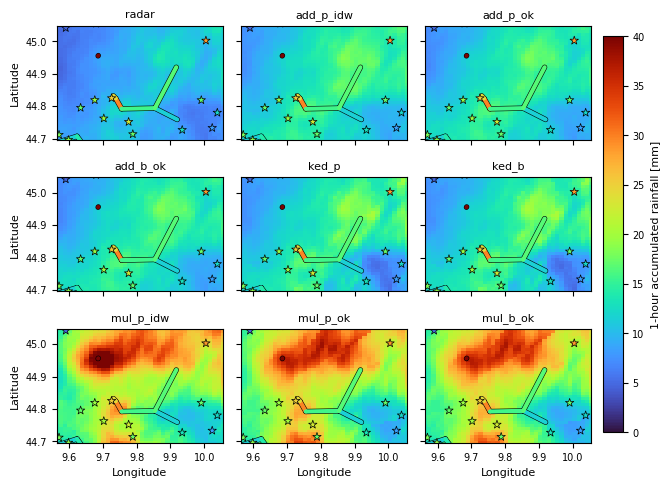

In [9]:
seltime = '2022-08-18T10:00'

target_lon = np.nanmean(ds_rad.x_grid.sel(x=9.8, method='nearest').values)
target_lat = np.nanmean(ds_rad.y_grid.sel(y=44.85, method='nearest').values)
low_lon = target_lon - 20000
up_lon = target_lon + 20000
low_lat = target_lat - 20000
up_lat = target_lat + 20000
mask = (ds_rad.x_grid >=  low_lon)&(ds_rad.x_grid <=  up_lon)&(ds_rad.y_grid >=  low_lat)&(ds_rad.y_grid <=  up_lat)
ds_rad_cut = ds_rad.where(mask, drop=True)
low_lon = np.nanmin(ds_rad_cut.lon)
low_lat = np.nanmin(ds_rad_cut.lat)
up_lon = np.nanmax(ds_rad_cut.lon)
up_lat = np.nanmax(ds_rad_cut.lat)

fig, ax = plt.subplots(3, 3, figsize=(6.5, 5), sharex=True, sharey=True)
axes = ax.flatten()

# Colormap settings
cmap = "turbo"
vmin, vmax = 0, 40
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for i in range(0, len(axes)):
    plg.plot_map.plot_plg(
        da_grid=ds_rad[fields[i]].sel(time=seltime),
        da_gauges=ds_gauges.rainfall_amount.sel(time=seltime),
        da_cmls=ds_cmls.sel(time=seltime),
        use_lon_lat=True,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False,
        ax=axes[i],
        kwargs_cmls_plot={"edge_color": "black", "edge_width": 0.8, "line_width": 3},
        kwargs_gauges_plot={"edge_color": "black", "s": 40, "marker": "*"}
    )
    axes[i].set_title(fields[i], fontsize=8)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_xlim([low_lon, up_lon])
    axes[i].set_ylim([low_lat, up_lat])

# Axis labels only on outer edges
for i in [0, 3, 6]:
    axes[i].set_ylabel('Latitude', fontsize=8)
for i in [6, 7, 8]:
    axes[i].set_xlabel('Longitude', fontsize=8)

# Compact layout and shared colorbar
plt.tight_layout(pad=1.0)
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.035, pad=0.02)
cbar.set_label('1-hour accumulated rainfall [mm]', fontsize=8)
cbar.ax.tick_params(labelsize=7)

# Consistent tick label size
for ax in axes:
    ax.tick_params(axis='both', labelsize=7)

# Save figure for Overleaf
fig.savefig('OpenRainER_case_study.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
names = ['rad_dif', 'add_p_idw_dif', 'add_p_ok_dif', 
         'add_b_ok_dif', 'ked_p_dif', 'ked_b_dif', 
         'mul_p_idw_dif', 'mul_p_ok_dif', 'mul_b_ok_dif']

for field, name in zip(fields, names):
    ds_rad[name] = ds_rad['radar'] - ds_rad[field]


get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), 
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best" 
)

for field, name in zip(fields, names):
    ds_gauges[field] = get_grid_at_points(
        da_gridded_data=ds_rad[field],
        da_point_data=ds_gauges.rainfall_amount,  
    )
    ds_gauges[name] = ds_gauges['rainfall_amount'] - ds_gauges[field]

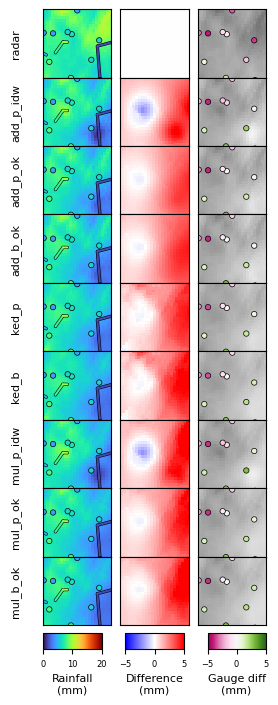

In [11]:
# -------------------------------
# 1️⃣ Configuration
# -------------------------------
seltime = '2022-08-18T10:00'

diff_fields = [
    'rad_dif', 'add_p_idw_dif', 'add_p_ok_dif',
    'add_b_ok_dif', 'ked_p_dif', 'ked_b_dif',
    'mul_p_idw_dif', 'mul_p_ok_dif', 'mul_b_ok_dif'
]

# -------------------------------
# 2️⃣ Define map extents
# -------------------------------
target_lon = np.nanmean(ds_rad.x_grid.sel(x=11.8, method='nearest').values)
target_lat = np.nanmean(ds_rad.y_grid.sel(y=44.2, method='nearest').values)

low_lon = target_lon - 12000
up_lon = target_lon + 12000
low_lat = target_lat - 12000
up_lat = target_lat + 12000

# -------------------------------
# 3️⃣ Figure and colormap settings
# -------------------------------
fig, ax = plt.subplots(9, 3, figsize=(3,8), sharex=True, sharey=True)

vmin_rmap, vmax_rmap = 0, 20
cmap_rmap = "turbo"

vmin_dmap, vmax_dmap = -5, 5
cmap_dmap = "bwr"
norm_dmap = mpl.colors.Normalize(vmin=vmin_dmap, vmax=vmax_dmap)

vmin_rg, vmax_rg = -5, 5
cmap_rg = "PiYG"
norm_rg = mpl.colors.Normalize(vmin=vmin_rg, vmax=vmax_rg)

# -------------------------------
# 4️⃣ Plot maps
# -------------------------------
for i in range(9):
    # First column: radar + gauges
    plg.plot_map.plot_plg(
        da_grid=ds_rad[fields[i]].sel(time=seltime),
        da_gauges=ds_gauges.rainfall_amount.sel(time=seltime),
        da_cmls=ds_cmls.sel(time=seltime),
        use_lon_lat=False,
        vmin=vmin_rmap, vmax=vmax_rmap,
        add_colorbar=False,
        ax=ax[i, 0],
        kwargs_cmls_plot={"edge_color": "black", "edge_width": 0.8, "line_width": 1.5},
        kwargs_gauges_plot={"edge_color": "black", "s": 15}
    )
    ax[i, 0].set_xlim([low_lon, up_lon])
    ax[i, 0].set_ylim([low_lat, up_lat])
    ax[i, 0].set_title('')
    ax[i, 0].set_xlabel('')
    ax[i, 0].set_ylabel('')
    ax[i, 0].tick_params(axis='both', labelsize=6)
    ax[i, 0].set_aspect('equal')  # 
    ax[i, 0].text(-0.32, 0.5, fields[i], va='center', ha='right',
                  rotation='vertical', fontsize=8, transform=ax[i, 0].transAxes)
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    # Second column: field differences
    ds_rad[diff_fields[i]].sel(time=seltime).plot(
        ax=ax[i, 1],
        x='x_grid', y='y_grid',
        vmin=vmin_dmap, vmax=vmax_dmap,
        cmap=cmap_dmap, norm=norm_dmap,
        add_colorbar=False
    )
    ax[i, 1].set_xlim([low_lon, up_lon])
    ax[i, 1].set_ylim([low_lat, up_lat])
    ax[i, 1].set_title('')
    ax[i, 1].set_xlabel('')
    ax[i, 1].set_ylabel('')
    ax[i, 1].tick_params(axis='both', labelsize=6)
    ax[i, 1].set_aspect('equal')
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

    # Third column: gray map + gauge differences
    ds_rad[fields[i]].sel(time=seltime).plot(
        ax=ax[i, 2],
        x='x_grid', y='y_grid',
        vmin=vmin_rmap, vmax=vmax_rmap,
        cmap='binary',
        add_colorbar=False
    )
    ax[i, 2].scatter(
        ds_gauges.x, ds_gauges.y,
        cmap=cmap_rg, norm=norm_rg,
        c=ds_gauges[diff_fields[i]].sel(time=seltime),
        edgecolor='black',
        s=15, linewidth=0.5
    )
    ax[i, 2].set_xlim([low_lon, up_lon])
    ax[i, 2].set_ylim([low_lat, up_lat])
    ax[i, 2].set_title('')
    ax[i, 2].set_xlabel('')
    ax[i, 2].set_ylabel('')
    ax[i, 2].tick_params(axis='both', labelsize=6)
    ax[i, 2].set_aspect('equal')
    ax[i, 2].set_xticks([])
    ax[i, 2].set_yticks([])

# -------------------------------
# 5️⃣ Add horizontal colorbars below each column
# -------------------------------
# Ottieni posizione del primo subplot di ogni colonna
pos1 = ax[-1,0].get_position()
pos2 = ax[-1,1].get_position()
pos3 = ax[-1,2].get_position()

# Crea colorbar esattamente sotto ciascuna colonna
cbar_ax1 = fig.add_axes([pos1.x0, pos1.y0 - 0.03, pos1.width, 0.02])
cbar_ax2 = fig.add_axes([pos2.x0, pos2.y0 - 0.03, pos2.width, 0.02])
cbar_ax3 = fig.add_axes([pos3.x0, pos3.y0 - 0.03, pos3.width, 0.02])

cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin_rmap, vmax=vmax_rmap),
                                         cmap=cmap_rmap), cax=cbar_ax1, orientation='horizontal')
cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_dmap, cmap=cmap_dmap),
                   cax=cbar_ax2, orientation='horizontal')
cb3 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_rg, cmap=cmap_rg),
                   cax=cbar_ax3, orientation='horizontal')

cb1.set_label('Rainfall\n(mm)', fontsize=8)
cb2.set_label('Difference\n(mm)', fontsize=8)
cb3.set_label('Gauge diff\n(mm)', fontsize=8)
for cb in [cb1, cb2, cb3]:
    cb.ax.tick_params(labelsize=6)

# -------------------------------
# 6️⃣ Reduce spacing between subplots
# -------------------------------
plt.subplots_adjust(hspace=0, wspace=0)  # tight vertical and horizontal spacing

# -------------------------------
# 7️⃣ Save figure
# -------------------------------
fig.savefig('OpenRainER_fullcase.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()